<a href="https://colab.research.google.com/github/OlegBEZb/emotion_classification/blob/main/transformers_doc/tensorflow/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
# Transformers installation
! pip install transformers
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git


## Getting the Data and Preview it
Below we are going to load the data and show you how to create the splits. However, we don't need to split the data manually becuase I have already created the splits and stored those files seperately which you can quickly download below:

https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp/code


In [2]:
# %%capture 
# !wget https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
# !wget https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
# !wget https://www.dropbox.com/s/2mzialpsgf9k5l3/val.txt

In [3]:
# with open('train.txt') as f:
#     print(f.read()[:1000])

In [4]:
## export the datasets as txt files
## EXERCISE: Change this to an address

# train_path = "train.txt"
# test_path = "test.txt"
# val_path = "val.txt"

## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

In [5]:
!wget https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl

--2021-06-11 09:51:42--  https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/607ptdakxuh5i4s/merged_training.pkl [following]
--2021-06-11 09:51:43--  https://www.dropbox.com/s/raw/607ptdakxuh5i4s/merged_training.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3b9c337d6c2537b2a11ba05c88.dl.dropboxusercontent.com/cd/0/inline/BQM1nao8gLWy5Mk6WLtL5Xdg626cQa9ua-Q3rfTaEoqn0Sf6gHPASuFkTHYvQq29Fp6IKdcXzRn6xju1_IhdwEZPKaQ2qdlFPsBH08KJ2THTJJ5rFvecBfpQ5pz63KjQnDO-AMwLg087I20mDTkd4CmP/file# [following]
--2021-06-11 09:51:43--  https://uc3b9c337d6c2537b2a11ba05c88.dl.dropboxusercontent.com/cd/0/inline/BQM1nao8gLWy5Mk6WLtL5Xdg626cQa9ua-Q3rfTaEoqn0Sf6gHPASuFkTHYvQq29Fp6IK

In [6]:
import pickle

## helper function
def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

(416809, 2)


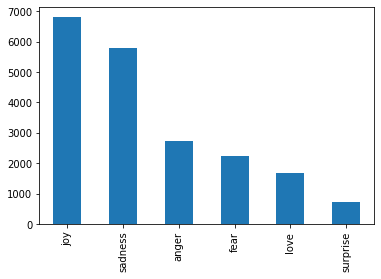

In [7]:
data = load_from_pickle(directory="merged_training.pkl")

## using a sample
emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]
data = data[data["emotions"].isin(emotions)]

print(data.shape)


data = data.sample(n=20000);

data.emotions.value_counts().plot.bar()

Data has been preprocessed already, using technique from this paper: https://www.aclweb.org/anthology/D18-1404/

In [8]:
data.head()

,text,emotions
87059,i remember feeling dismayed from this observation,sadness
22961,i live on the jersey shore and feel blessed th...,love
40365,i was in a state of shock feeling a bit fright...,fear
121838,i was reminded of this when yesterday i read o...,joy
18893,i do feel betrayed and i feel abused by this c...,sadness


In [9]:
## reset index
data.reset_index(drop=True, inplace=True)

In [10]:
## check unique emotions in the dataset
data.emotions.unique()

array(['sadness', 'love', 'fear', 'joy', 'anger', 'surprise'],
      dtype=object)

## Split the data and store into individual text files

In [11]:
## uncomment the code below to generate the text files for your train, val, and test datasets.

from sklearn.model_selection import train_test_split
import pandas as pd

# Creating training and validation sets using an 80-20 split
input_train, input_val, train_labels, val_labels = train_test_split(data.text.to_list(), 
                                                                    data.emotions.map(label2int).to_numpy(), 
                                                                    # data.emotions.to_numpy(), 
                                                                    test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_val, input_test, val_labels, test_labels = train_test_split(input_val, val_labels, test_size=0.5)


## create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": input_train, "class": train_labels})
val_dataset = pd.DataFrame(data={"text": input_val, "class": val_labels})
test_dataset = pd.DataFrame(data={"text": input_test, "class": test_labels})
final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

# train_dataset.to_csv(train_path, sep=";",header=False, index=False)
# val_dataset.to_csv(test_path, sep=";",header=False, index=False)
# test_dataset.to_csv(val_path, sep=";",header=False, index=False)

## Preparing the datasets

In [12]:
from transformers import AutoTokenizer

# Define the model repo
model_name = "distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [13]:
train_encodings = tokenizer(input_train, truncation=True, padding=True)
val_encodings = tokenizer(input_val, truncation=True, padding=True)
test_encodings = tokenizer(input_test, truncation=True, padding=True)

In [14]:
import torch 
class EmoDataset(torch.utils.data.Dataset):
    # def __init__(self, path):
        # super().__init__()
        # self.data_column = "text"
        # self.class_column = "class"
        # self.data = pd.read_csv(path, sep=";", header=None, 
        #                         names=[self.data_column, self.class_column],
        #                         engine="python")
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels


    # def __getitem__(self, idx):
    #     return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    # def __len__(self):
    #     return self.data.shape[0]
    def __len__(self):
        return len(self.labels)

In [15]:
train_dataset = EmoDataset(train_encodings, train_labels)
val_dataset = EmoDataset(val_encodings, val_labels)
test_dataset = EmoDataset(test_encodings, test_labels)

# Fine-tuning in PyTorch with the Trainer API

Since PyTorch does not provide a training loop, the 🤗 Transformers library provides a `Trainer`
API that is optimized for 🤗 Transformers models, with a wide range of training options and with built-in features like
logging, gradient accumulation, and mixed precision.

First, let's define our model:

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

del tokenizer
# del model
# del trainer
torch.cuda.empty_cache()

cuda


In [17]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                           num_labels=len(label2int))

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.weig

This will issue a warning about some of the pretrained weights not being used and some weights being randomly
initialized. That's because we are throwing away the pretraining head of the BERT model to replace it with a
classification head which is randomly initialized. We will fine-tune this model on our task, transferring the knowledge
of the pretrained model to it (which is why doing this is called transfer learning).

Then, to define our `Trainer`, we will need to instantiate a
`TrainingArguments`. This class contains all the hyperparameters we can tune for the
`Trainer` or the flags to activate the different training options it supports. Let's begin by
using all the defaults, the only thing we then have to provide is a directory in which the checkpoints will be saved:

In [18]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,
)

Then we can instantiate a `Trainer` like this:

In [20]:
from transformers import TrainerCallback

class PrinterCallback(TrainerCallback):

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero:
            print(logs)

In [19]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer_output = trainer.train()

Step,Training Loss
10,1.773100
20,1.764200
30,1.747000
40,1.710600
50,1.677300
60,1.621700
70,1.593600
80,1.427600
90,1.316600
100,1.175900


TrainOutput(global_step=750, training_loss=0.5008888046741485, metrics={'train_runtime': 318.2027, 'train_samples_per_second': 2.357, 'total_flos': 559750463424000.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 2475827200, 'init_mem_gpu_alloc_delta': 329790464, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 13963264, 'train_mem_gpu_alloc_delta': 1009246720, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 1800755200})

In [ ]:
model.

In [105]:
# from torch.utils.data import DataLoader, Dataset
# class EmoDataset(Dataset):
#     def __init__(self, path):
#         super().__init__()
#         self.data_column = "text"
#         self.class_column = "class"
#         self.data = pd.read_csv(path, sep=";", header=None, 
#                                 names=[self.data_column, self.class_column],
#                                 engine="python")
#         print(path)
#         display(self.data.head(2))

#     def __getitem__(self, idx):
#         return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

#     def __len__(self):
#         return self.data.shape[0]

# import torch

# class TokenizersCollateFn:
#     def __init__(self, tokenizer):
#         self.tokenizer = tokenizer

#     def __call__(self, batch):
#         # encoded = self.tokenizer.encode_batch([x[0] for x in batch])
#         encoded = self.tokenizer([x[0] for x in batch], 
#                    max_length=150, padding=True, truncation=True, 
#                    return_tensors="pt")
        
#         sequences_padded = torch.tensor([enc.ids for enc in encoded])
#         attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
#         labels = torch.tensor([x[1] for x in batch])
        
#         return (sequences_padded, attention_masks_padded), labels
#         # return inputs, labels

which will start a training that you can follow with a progress bar, which should take a couple of minutes to complete
(as long as you hav access to a GPU). It won't actually tell you anything useful about how well (or badly) your model
is performing however as by default, there is no evaluation during training, and we didn't tell the
`Trainer` to compute any metrics. Let's have a look on how to do that now!

To have the `Trainer` compute and report metrics, we need to give it a `compute_metrics`
function that takes predictions and labels (grouped in a namedtuple called `EvalPrediction`) and
return a dictionary with string items (the metric names) and float values (the metric values).

The 🤗 Datasets library provides an easy way to get the common metrics used in NLP with the `load_metric` function.
here we simply use accuracy. Then we define the `compute_metrics` function that just convert logits to predictions
(remember that all 🤗 Transformers models return the logits) and feed them to `compute` method of this metric.

In [ ]:
!pip install datasets

In [40]:
import numpy as np
from datasets import load_metric
from sklearn.metrics import roc_auc_score

metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metrics_dict = metric.compute(predictions=predictions, references=labels)
    # metrics_dict.update({'roc_auc': roc_auc_score(labels, predictions, average='micro', multi_class='ovr')})
    return metrics_dict

The compute function needs to receive a tuple (with logits and labels) and has to return a dictionary with string keys
(the name of the metric) and float values. It will be called at the end of each evaluation phase on the whole arrays of
predictions/labels.

To check if this works on practice, let's create a new `Trainer` with our fine-tuned model:

In [41]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)
trainer.evaluate()

{'eval_accuracy': 0.9315,
 'eval_loss': 0.1418095827102661,
 'eval_mem_cpu_alloc_delta': 8192,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 149354496,
 'eval_runtime': 4.3099,
 'eval_samples_per_second': 464.052,
 'init_mem_cpu_alloc_delta': 4096,
 'init_mem_cpu_peaked_delta': 0,
 'init_mem_gpu_alloc_delta': 0,
 'init_mem_gpu_peaked_delta': 0}

which showed an accuracy of 87.5% in our case.

If you want to fine-tune your model and regularly report the evaluation metrics (for instance at the end of each
epoch), here is how you should define your training arguments:

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments("test_trainer", evaluation_strategy="epoch")

See the documentation of `TrainingArguments` for more options.

Let's now see how to achieve the same results as in [trainer section](#trainer) in PyTorch. First we need to
define the dataloaders, which we will use to iterate over batches. We just need to apply a bit of post-processing to
our `tokenized_datasets` before doing that to:

- remove the columns corresponding to values the model does not expect (here the `"text"` column)
- rename the column `"label"` to `"labels"` (because the model expect the argument to be named `labels`)
- set the format of the datasets so they return PyTorch Tensors instead of lists.

Our *tokenized_datasets* has one method for each of those steps:

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

Now that this is done, we can easily define our dataloaders:

In [140]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(tokenized_train, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(tokenized_val, batch_size=8)

Next, we define our model:

In [141]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                           num_labels=3)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 

We are almost ready to write our training loop, the only two things are missing are an optimizer and a learning rate
scheduler. The default optimizer used by the `Trainer` is `AdamW`:

In [142]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

Finally, the learning rate scheduler used by default it just a linear decay form the maximum value (5e-5 here) to 0:

In [143]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

One last thing, we will want to use the GPU if we have access to one (otherwise training might take several hours
instead of a couple of minutes). To do this, we define a `device` we will put our model and our batches on.

In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

We now are ready to train! To get some sense of when it will be finished, we add a progress bar over our number of
training steps, using the *tqdm* library.

In [145]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

TypeError: ignored

Note that if you are used to freezing the body of your pretrained model (like in computer vision) the above may seem a
bit strange, as we are directly fine-tuning the whole model without taking any precaution. It actually works better
this way for Transformers model (so this is not an oversight on our side). If you're not familiar with what "freezing
the body" of the model means, forget you read this paragraph.

Now to check the results, we need to write the evaluation loop. Like in the [trainer section](#trainer) we will
use a metric from the datasets library. Here we accumulate the predictions at each batch before computing the final
result when the loop is finished.

In [ ]:
metric= load_metric("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

<a id='additional-resources'></a>

## Additional resources

To look at more fine-tuning examples you can refer to:

- [🤗 Transformers Examples](https://github.com/huggingface/transformers/tree/master/examples) which includes scripts
  to train on all common NLP tasks in PyTorch and TensorFlow.

- [🤗 Transformers Notebooks](https://huggingface.co/transformers/notebooks.html) which contains various notebooks and in particular one per task (look
  for the *how to finetune a model on xxx*).